In [11]:
import os
import inspect
import csv as csv
import re
import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNetCV, ElasticNet
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.tree import _tree, DecisionTreeRegressor, plot_tree
from sklearn.feature_selection import mutual_info_regression, RFE, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import (
    log_loss,
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    make_scorer,
    classification_report
)
from lightgbm import LGBMRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor

import xgboost as xgb

from category_encoders import TargetEncoder



In [2]:
df = pd.read_csv('pca2.csv')
df.head()

,SERIALNO,SPORDER,WAGP,AGEP,COW,SCHL,SEX,WKHP,ESR,NAICSP,RAC1P,HISP,INDP,OCCP,SCIENGP,SCIENGRLP,RACE
0,2023000000009,1,3600,19,1,19,2,16,1,7220,8,2,8680,4055,3,3,0
1,2023000000028,1,800,23,1,19,1,15,1,7115,1,1,8564,2850,3,3,1
2,2023000000052,1,1800,23,1,20,1,15,1,7115,1,1,8564,2850,3,3,1
3,2023000000125,1,65000,28,1,19,1,40,6,4492,9,2,4796,4760,3,3,0
4,2023000000152,1,3000,20,1,19,2,20,6,61101,2,1,7870,4640,3,3,2


# Feature Transformation

In [3]:
# Ensure SCHL is an integer type before mapping
df['SCHL'] = df['SCHL'].astype(int)

# Define the education level mapping
edu_mapping = {
    15: 'High school',
    19: 'High school graduate',
    20: 'Associates',
    21: 'Bachelors',
    22: 'Masters',
    23: 'Professional degree beyond bachelors',
    24: 'Doctorate'
}

# Apply the mapping
df['SCHL'] = df['SCHL'].map(edu_mapping)

# Convert to categorical encoding
df['SCHL_Encoded'] = df['SCHL'].astype('category').cat.codes

# Display transformed dataset
print(df.head())


        SERIALNO  SPORDER   WAGP  AGEP  COW                  SCHL  SEX  WKHP  \
0  2023000000009        1   3600    19    1  High school graduate    2    16   
1  2023000000028        1    800    23    1  High school graduate    1    15   
2  2023000000052        1   1800    23    1            Associates    1    15   
3  2023000000125        1  65000    28    1  High school graduate    1    40   
4  2023000000152        1   3000    20    1  High school graduate    2    20   

   ESR  NAICSP  RAC1P  HISP  INDP  OCCP  SCIENGP  SCIENGRLP  RACE  \
0    1    7220      8     2  8680  4055        3          3     0   
1    1    7115      1     1  8564  2850        3          3     1   
2    1    7115      1     1  8564  2850        3          3     1   
3    6    4492      9     2  4796  4760        3          3     0   
4    6   61101      2     1  7870  4640        3          3     2   

   SCHL_Encoded  
0             4  
1             4  
2             0  
3             4  
4             

In [ ]:


# 1. Convert COW (Class of Worker) to categorical encoding
df['COW'] = df['COW'].astype('category')

# 2. Bin WKHP (Worked Hours Per Week)
df['WKHP_Binned'] = pd.cut(df['WKHP'], bins=[0, 30, 45, np.inf], labels=['Part-Time', 'Full-Time', 'Overtime'])

# 3. Convert INDP (Industry Code) to categorical encoding
df['INDP'] = df['INDP'].astype('category')

# Display transformed dataset
print(df.head())


        SERIALNO  SPORDER   WAGP  AGEP COW                  SCHL  SEX  WKHP  \
0  2023000000009        1   3600    19   1  High school graduate    2    16   
1  2023000000028        1    800    23   1  High school graduate    1    15   
2  2023000000052        1   1800    23   1            Associates    1    15   
3  2023000000125        1  65000    28   1  High school graduate    1    40   
4  2023000000152        1   3000    20   1  High school graduate    2    20   

   ESR  NAICSP  RAC1P  HISP  INDP  OCCP  SCIENGP  SCIENGRLP  RACE  \
0    1    7220      8     2  8680  4055        3          3     0   
1    1    7115      1     1  8564  2850        3          3     1   
2    1    7115      1     1  8564  2850        3          3     1   
3    6    4492      9     2  4796  4760        3          3     0   
4    6   61101      2     1  7870  4640        3          3     2   

   SCHL_Encoded AGEP_Binned WKHP_Binned  
0             4       Young   Part-Time  
1             4       Youn

In [5]:


def remove_top_5_percent(df, target_feature):
    """
    Removes the top 5% of values from the specified target feature in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    target_feature (str): The column name of the target feature.

    Returns:
    pd.DataFrame: A new DataFrame with the top 5% of values removed.
    """
    threshold = df[target_feature].quantile(0.95)  # Calculate 95th percentile
    return df[df[target_feature] <= threshold]  # Keep only values below the threshold

df_clean = remove_top_5_percent(df, 'WAGP')
print(len(df_clean))

177800


In [6]:
df_clean = pd.get_dummies(df_clean, columns=['COW', 'WKHP_Binned'], drop_first=True)
print(df_clean.columns)

Index(['SERIALNO', 'SPORDER', 'WAGP', 'AGEP', 'SCHL', 'SEX', 'WKHP', 'ESR',
       'NAICSP', 'RAC1P', 'HISP', 'INDP', 'OCCP', 'SCIENGP', 'SCIENGRLP',
       'RACE', 'SCHL_Encoded', 'AGEP_Binned', 'COW_2', 'COW_3', 'COW_4',
       'COW_5', 'COW_6', 'COW_7', 'COW_8', 'WKHP_Binned_Full-Time',
       'WKHP_Binned_Overtime'],
      dtype='object')


In [ ]:
encoder = TargetEncoder(cols=['INDP'])
df_clean['INDP_Encoded'] = encoder.fit_transform(df_clean['INDP'], df_clean['WAGP'])  


In [23]:
df_clean['WAGP_Log'] = np.log1p(df_clean['WAGP'])  # Log transform to normalize
df_clean.head()

,SERIALNO,SPORDER,WAGP,AGEP,SCHL,SEX,WKHP,ESR,NAICSP,RAC1P,...,COW_3,COW_4,COW_5,COW_6,COW_7,COW_8,WKHP_Binned_Full-Time,WKHP_Binned_Overtime,INDP_Encoded,WAGP_Log
0,2023000000009,1,3600,19,High school graduate,2,16,1,7220,8,...,0,0,0,0,0,0,0,0,26657.642359,8.188967
1,2023000000028,1,800,23,High school graduate,1,15,1,7115,1,...,0,0,0,0,0,0,0,0,53110.831826,6.685861
2,2023000000052,1,1800,23,Associates,1,15,1,7115,1,...,0,0,0,0,0,0,0,0,53110.831826,7.496097
3,2023000000125,1,65000,28,High school graduate,1,40,6,4492,9,...,0,0,0,0,0,0,1,0,66865.645412,11.082158
4,2023000000152,1,3000,20,High school graduate,2,20,6,61101,2,...,0,0,0,0,0,0,0,0,55722.197783,8.006701


# Modeling and experimentation

In [25]:


# Copy dataset
dfStack = df_clean.copy()

# Define target variable
y = dfStack['WAGP_Log'] 

# Drop unnecessary columns
X = dfStack.drop(columns=['WAGP', 'SCIENGRLP', 'SCHL', 'INDP', 'WAGP_Log'])

# Feature Engineering
X['AGEP_WKHP_Interaction'] = X['AGEP'] * X['WKHP']
X['EDU_WKHP_Interaction'] = X['SCHL_Encoded'] * X['WKHP']
X['OCCP_AGE'] = X['AGEP'] * X['OCCP']

# Standardize numerical features
num_features = ['AGEP', 'WKHP', 'INDP_Encoded']
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])



# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Define models
xgb_model = XGBRegressor(
    n_estimators=6200,
    learning_rate=0.006,
    max_depth=12,
    min_child_weight=3,
    colsample_bytree=0.75,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=1234
)

lgbm_model = LGBMRegressor(
    n_estimators=6200,
    learning_rate=0.007,
    max_depth=12,
    num_leaves=30,
    colsample_bytree=0.75,
    subsample=0.9,
    min_child_samples=10,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=1234
)

# Train both models
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# Blended prediction
y_pred_blended = (0.52 * y_pred_xgb) + (0.48 * y_pred_lgbm)

# Evaluate
r2_blended = r2_score(y_test, y_pred_blended)
print(f"Blended Model R-squared Score: {r2_blended:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1920
[LightGBM] [Info] Number of data points in the train set: 142240, number of used features: 26
[LightGBM] [Info] Start training from score 10.525211
Blended Model R-squared Score: 0.6365


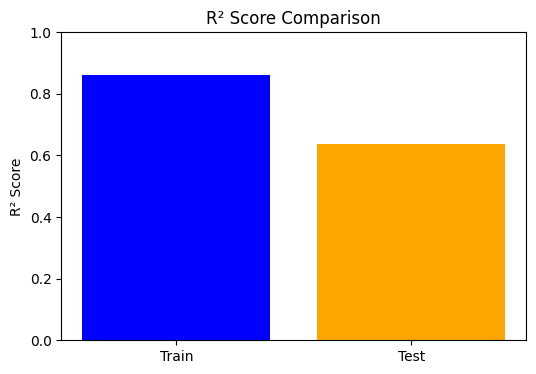

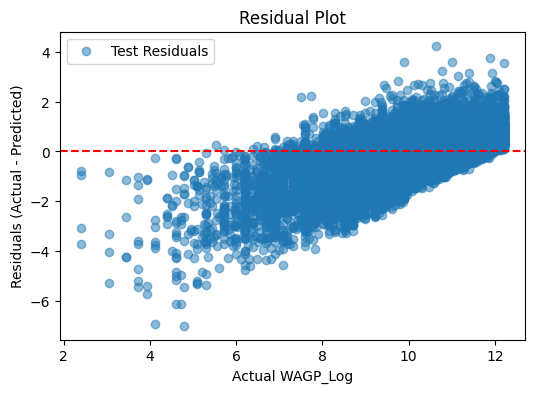

C:\Users\rohan\AppData\Local\Temp\ipykernel_8068\1639585244.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train_sample = y_train[:int(size * len(y_train))]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 14224, number of used features: 26
[LightGBM] [Info] Start training from score 10.503925


C:\Users\rohan\AppData\Local\Temp\ipykernel_8068\1639585244.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train_sample = y_train[:int(size * len(y_train))]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 28448, number of used features: 26
[LightGBM] [Info] Start training from score 10.513123


C:\Users\rohan\AppData\Local\Temp\ipykernel_8068\1639585244.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train_sample = y_train[:int(size * len(y_train))]


KeyboardInterrupt: 

In [ ]:
# Predictions on training data
y_train_pred_xgb = xgb_model.predict(X_train)
y_train_pred_lgbm = lgbm_model.predict(X_train)
y_train_pred_blended = (0.52 * y_train_pred_xgb) + (0.48 * y_train_pred_lgbm)

# Compute R2 for training and test sets
r2_train = r2_score(y_train, y_train_pred_blended)
r2_test = r2_score(y_test, y_pred_blended)

# Compute RMSE for better error distribution visualization
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_blended))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_blended))

# Plot R² scores
plt.figure(figsize=(6,4))
plt.bar(['Train', 'Test'], [r2_train, r2_test], color=['blue', 'orange'])
plt.ylim(0, 1)
plt.title("R² Score Comparison")
plt.ylabel("R² Score")
plt.show()

# Residual plot
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_test - y_pred_blended, alpha=0.5, label="Test Residuals")
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Actual WAGP_Log")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.legend()
plt.show()

# Learning curve plot
train_sizes = np.linspace(0.1, 1.0, 10)
train_scores, test_scores = [], []

for size in train_sizes:
    X_train_sample = X_train[:int(size * len(X_train))]
    y_train_sample = y_train[:int(size * len(y_train))]
    
    # Fit model on subsample
    xgb_model.fit(X_train_sample, y_train_sample)
    lgbm_model.fit(X_train_sample, y_train_sample)
    
    # Blended prediction
    y_train_sample_pred = (0.52 * xgb_model.predict(X_train_sample)) + (0.48 * lgbm_model.predict(X_train_sample))
    y_test_pred = (0.52 * xgb_model.predict(X_test)) + (0.48 * lgbm_model.predict(X_test))
    
    train_scores.append(r2_score(y_train_sample, y_train_sample_pred))
    test_scores.append(r2_score(y_test, y_test_pred))

# Plot learning curves
plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_scores, 'o-', label="Train Score")
plt.plot(train_sizes, test_scores, 'o-', label="Test Score")
plt.xlabel("Training Data Size")
plt.ylabel("R² Score")
plt.title("Learning Curve")
plt.legend()
plt.show()


# increase reg alpha and lambda, decrease max depth and estimtators

In [27]:

# Copy dataset
dfStack = df_clean.copy()

# Define target variable
y = dfStack['WAGP_Log'] 

# Drop unnecessary columns
X = dfStack.drop(columns=['WAGP', 'SCIENGRLP', 'SCHL', 'INDP', 'WAGP_Log'])

# Feature Engineering
X['AGEP_WKHP_Interaction'] = X['AGEP'] * X['WKHP']
X['EDU_WKHP_Interaction'] = X['SCHL_Encoded'] * X['WKHP']
X['OCCP_AGE'] = X['AGEP'] * X['OCCP']

# Standardize numerical features
num_features = ['AGEP', 'WKHP', 'INDP_Encoded']
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])



# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Define models
xgb_model = XGBRegressor(
    n_estimators=5500,
    learning_rate=0.006,
    max_depth=10,
    min_child_weight=3,
    colsample_bytree=0.75,
    subsample=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5,
    random_state=1234
)

lgbm_model = LGBMRegressor(
    n_estimators=5500,
    learning_rate=0.007,
    max_depth=10,
    num_leaves=30,
    colsample_bytree=0.75,
    subsample=0.9,
    min_child_samples=10,
    reg_alpha=0.5,
    reg_lambda=0.5,
    random_state=1234
)

# Train both models
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# Blended prediction
y_pred_blended = (0.52 * y_pred_xgb) + (0.48 * y_pred_lgbm)

# Evaluate
r2_blended = r2_score(y_test, y_pred_blended)
print(f"Blended Model R-squared Score: {r2_blended:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1920
[LightGBM] [Info] Number of data points in the train set: 142240, number of used features: 26
[LightGBM] [Info] Start training from score 10.525211
Blended Model R-squared Score: 0.6327


# are artifical features adding too much complexity? try removing and training. or removing insignificant features and training - feature importance

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1920
[LightGBM] [Info] Number of data points in the train set: 142240, number of used features: 26
[LightGBM] [Info] Start training from score 10.525211


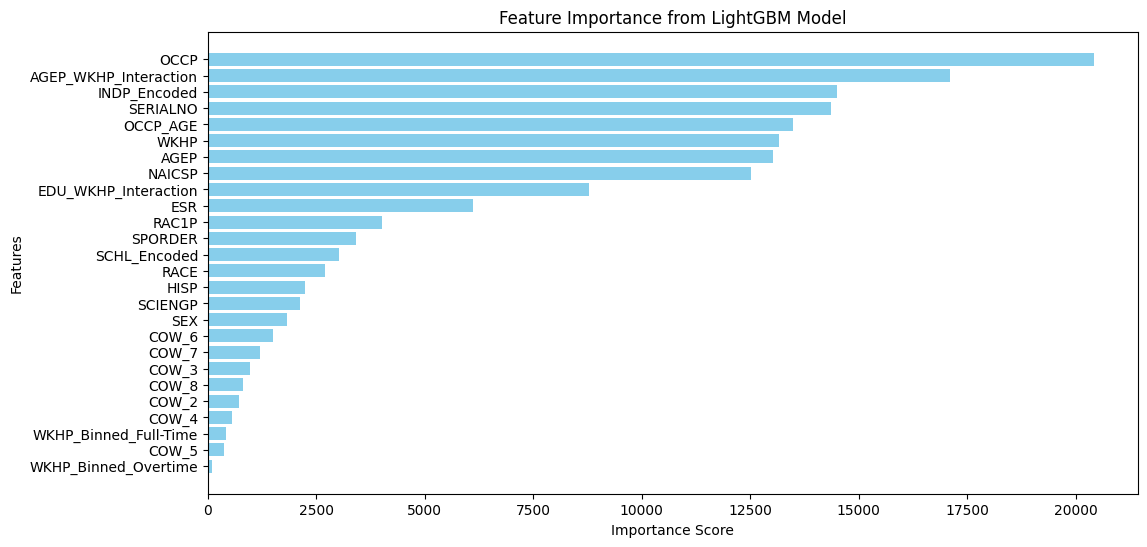

In [ ]:
lgbm_model.fit(X_train, y_train)

# Get feature importance from the LightGBM model
feature_importance = lgbm_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from LightGBM Model')
plt.gca().invert_yaxis()  
plt.show()


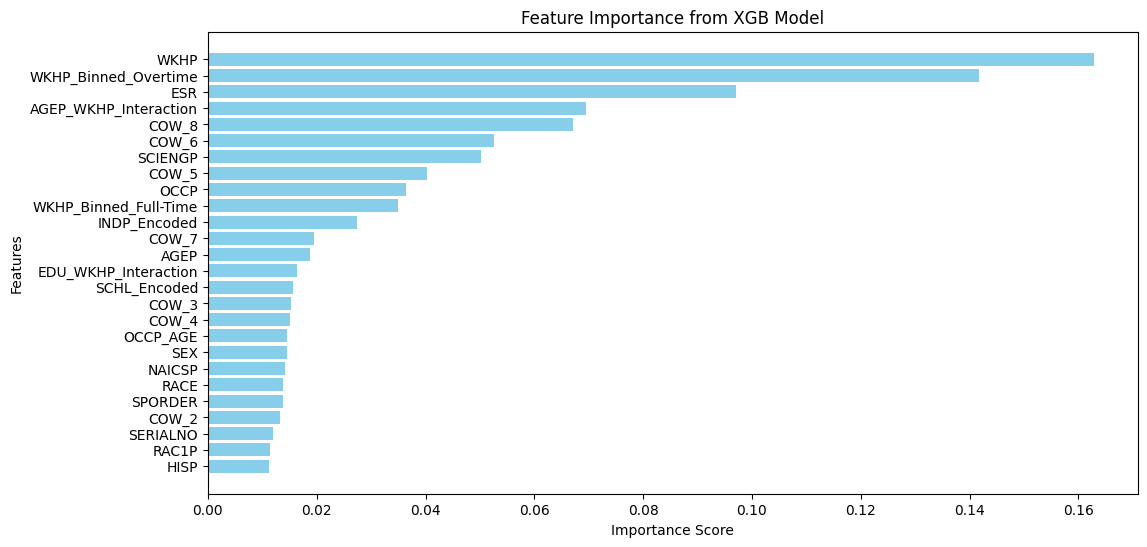

In [ ]:
xgb_model.fit(X_train, y_train)

# Get feature importance from the LightGBM model
feature_importance = xgb_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from XGB Model')
plt.gca().invert_yaxis()  
plt.show()


## remove artifical features and scaling

In [30]:


# Copy dataset
dfStack = df_clean.copy()

# Define target variable
y = dfStack['WAGP_Log'] 

# Drop unnecessary columns
X = dfStack.drop(columns=['WAGP', 'SCIENGRLP', 'SCHL', 'INDP', 'WAGP_Log'])

# Feature Engineering
#X['AGEP_WKHP_Interaction'] = X['AGEP'] * X['WKHP']
#X['EDU_WKHP_Interaction'] = X['SCHL_Encoded'] * X['WKHP']
#X['OCCP_AGE'] = X['AGEP'] * X['OCCP']

# Standardize numerical features
#num_features = ['AGEP', 'WKHP', 'INDP_Encoded']
#scaler = StandardScaler()
#X[num_features] = scaler.fit_transform(X[num_features])



# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Define models
xgb_model = XGBRegressor(
    n_estimators=6200,
    learning_rate=0.006,
    max_depth=12,
    min_child_weight=3,
    colsample_bytree=0.75,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=1234
)

lgbm_model = LGBMRegressor(
    n_estimators=6200,
    learning_rate=0.007,
    max_depth=12,
    num_leaves=30,
    colsample_bytree=0.75,
    subsample=0.9,
    min_child_samples=10,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=1234
)

# Train both models
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# Blended prediction
y_pred_blended = (0.52 * y_pred_xgb) + (0.48 * y_pred_lgbm)

# Evaluate
r2_blended = r2_score(y_test, y_pred_blended)
print(f"Blended Model R-squared Score: {r2_blended:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 142240, number of used features: 23
[LightGBM] [Info] Start training from score 10.525211
Blended Model R-squared Score: 0.6377


In [33]:
# Copy dataset
dfStack = df_clean.copy()

# Define target variable
y = dfStack['WAGP_Log'] 

# Drop unnecessary columns
X = dfStack.drop(columns=['WAGP', 'SCIENGRLP', 'SCHL', 'INDP', 'WAGP_Log', 'COW_2', 'HISP', 'COW_4'])

# Feature Engineering
X['AGEP_WKHP_Interaction'] = X['AGEP'] * X['WKHP']
X['EDU_WKHP_Interaction'] = X['SCHL_Encoded'] * X['WKHP']
X['OCCP_AGE'] = X['AGEP'] * X['OCCP']
X['OCCP_SQ'] = X['OCCP'] ** 2
X['WKHP_SQ'] = X['WKHP'] ** 2

# Standardize numerical features
num_features = ['AGEP', 'WKHP', 'INDP_Encoded']
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Define models
xgb_model = XGBRegressor(
    n_estimators=6200,
    learning_rate=0.006,
    max_depth=11,
    min_child_weight=3,
    colsample_bytree=0.75,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=1234
)

lgbm_model = LGBMRegressor(
    n_estimators=6200,
    learning_rate=0.007,
    max_depth=11,
    num_leaves=30,
    colsample_bytree=0.75,
    subsample=0.9,
    min_child_samples=10,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=1234
)

# Train both models
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# Blended prediction
y_pred_blended = (0.52 * y_pred_xgb) + (0.48 * y_pred_lgbm)

# Evaluate
r2_blended = r2_score(y_test, y_pred_blended)
print(f"Blended Model R-squared Score: {r2_blended:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 142240, number of used features: 30
[LightGBM] [Info] Start training from score 10.525211
Blended Model R-squared Score: 0.6353


## features low in both model importance: cow2, hisp, cow4

In [38]:
# Copy dataset
dfStack = df_clean.copy()

# Define target variable
y = dfStack['WAGP_Log'] 

# Drop unnecessary columns
X = dfStack.drop(columns=['WAGP', 'SCIENGRLP', 'SCHL', 'INDP', 'WAGP_Log', 'COW_2', 'HISP', 'COW_4'])

# Feature Engineering
X['AGEP_WKHP_Interaction'] = X['AGEP'] * X['WKHP']
X['EDU_WKHP_Interaction'] = X['SCHL_Encoded'] * X['WKHP']
X['OCCP_AGE'] = X['AGEP'] * X['OCCP']
X['OCCP_SQ'] = X['OCCP'] ** 2
X['WKHP_SQ'] = X['WKHP'] ** 2
X['OCCP_WKHP'] = X['OCCP'] * X['WKHP']

# Standardize numerical features
num_features = ['AGEP', 'WKHP', 'INDP_Encoded']
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Define models
xgb_model = XGBRegressor(
    n_estimators=6200,
    learning_rate=0.006,
    max_depth=11,
    min_child_weight=3,
    colsample_bytree=0.75,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=1234
)

lgbm_model = LGBMRegressor(
    n_estimators=6200,
    learning_rate=0.007,
    max_depth=11,
    num_leaves=30,
    colsample_bytree=0.75,
    subsample=0.9,
    min_child_samples=10,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=1234
)

# Train both models
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# Blended prediction
y_pred_blended = (0.52 * y_pred_xgb) + (0.48 * y_pred_lgbm)

# Evaluate
r2_blended = r2_score(y_test, y_pred_blended)
print(f"Blended Model R-squared Score: {r2_blended:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 142240, number of used features: 25
[LightGBM] [Info] Start training from score 10.525211
Blended Model R-squared Score: 0.6067


## add highly correlated features to the fourth power?

In [39]:
# Copy dataset
dfStack = df_clean.copy()

# Define target variable
y = dfStack['WAGP_Log'] 

# Drop unnecessary columns
X = dfStack.drop(columns=['WAGP', 'SCIENGRLP', 'SCHL', 'INDP', 'WAGP_Log'])

# Feature Engineering
X['AGEP_WKHP_Interaction'] = X['AGEP'] * X['WKHP']
X['EDU_WKHP_Interaction'] = X['SCHL_Encoded'] * X['WKHP']
X['OCCP_AGE'] = X['AGEP'] * X['OCCP']
X['OCCP4'] = X['OCCP']**4
X['AGEP4'] = X['AGEP'] ** 4
X['WKHP4'] = X['WKHP'] ** 4
# Standardize numerical features
num_features = ['AGEP', 'WKHP', 'INDP_Encoded']
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Define models
xgb_model = XGBRegressor(
    n_estimators=6200,
    learning_rate=0.006,
    max_depth=12,
    min_child_weight=3,
    colsample_bytree=0.75,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=1234
)

lgbm_model = LGBMRegressor(
    n_estimators=6200,
    learning_rate=0.007,
    max_depth=12,
    num_leaves=30,
    colsample_bytree=0.75,
    subsample=0.9,
    min_child_samples=10,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=1234
)

# Train both models
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# Blended prediction
y_pred_blended = (0.52 * y_pred_xgb) + (0.48 * y_pred_lgbm)

# Evaluate
r2_blended = r2_score(y_test, y_pred_blended)
print(f"Blended Model R-squared Score: {r2_blended:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2329
[LightGBM] [Info] Number of data points in the train set: 142240, number of used features: 28
[LightGBM] [Info] Start training from score 10.525211
Blended Model R-squared Score: 0.6071


# WKHP binned removal?

In [40]:
# Copy dataset
dfStack = df_clean.copy()

# Define target variable
y = dfStack['WAGP_Log'] 

# Drop unnecessary columns
X = dfStack.drop(columns=['WAGP', 'SCIENGRLP', 'SCHL', 'INDP', 'WAGP_Log', 'WKHP_Binned_Overtime', 'WKHP_Binned_Full-Time'])

# Feature Engineering
X['AGEP_WKHP_Interaction'] = X['AGEP'] * X['WKHP']
X['EDU_WKHP_Interaction'] = X['SCHL_Encoded'] * X['WKHP']
X['OCCP_AGE'] = X['AGEP'] * X['OCCP']

# Standardize numerical features
num_features = ['AGEP', 'WKHP', 'INDP_Encoded']
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Define models
xgb_model = XGBRegressor(
    n_estimators=6200,
    learning_rate=0.006,
    max_depth=12,
    min_child_weight=3,
    colsample_bytree=0.75,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=1234
)

lgbm_model = LGBMRegressor(
    n_estimators=6200,
    learning_rate=0.007,
    max_depth=12,
    num_leaves=30,
    colsample_bytree=0.75,
    subsample=0.9,
    min_child_samples=10,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=1234
)

# Train both models
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# Blended prediction
y_pred_blended = (0.52 * y_pred_xgb) + (0.48 * y_pred_lgbm)

# Evaluate
r2_blended = r2_score(y_test, y_pred_blended)
print(f"Blended Model R-squared Score: {r2_blended:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1909
[LightGBM] [Info] Number of data points in the train set: 142240, number of used features: 23
[LightGBM] [Info] Start training from score 10.525211
Blended Model R-squared Score: 0.6071


# See if can reduce num estimators. models take too long to continue experimenting at this lvl of granularity

In [41]:
# Copy dataset
dfStack = df_clean.copy()

# Define target variable
y = dfStack['WAGP_Log'] 

# Drop unnecessary columns
X = dfStack.drop(columns=['WAGP', 'SCIENGRLP', 'SCHL', 'INDP', 'WAGP_Log'])

# Feature Engineering
X['AGEP_WKHP_Interaction'] = X['AGEP'] * X['WKHP']
X['EDU_WKHP_Interaction'] = X['SCHL_Encoded'] * X['WKHP']
X['OCCP_AGE'] = X['AGEP'] * X['OCCP']

# Standardize numerical features
num_features = ['AGEP', 'WKHP', 'INDP_Encoded']
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])



# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Define models
xgb_model = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.006,
    max_depth=12,
    min_child_weight=3,
    colsample_bytree=0.75,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=1234
)

lgbm_model = LGBMRegressor(
    n_estimators=3000,
    learning_rate=0.006,
    max_depth=12,
    num_leaves=30,
    colsample_bytree=0.75,
    subsample=0.9,
    min_child_samples=10,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=1234
)

# Train both models
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# Blended prediction
y_pred_blended = (0.52 * y_pred_xgb) + (0.48 * y_pred_lgbm)

# Evaluate
r2_blended = r2_score(y_test, y_pred_blended)
print(f"Blended Model R-squared Score: {r2_blended:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1913
[LightGBM] [Info] Number of data points in the train set: 142240, number of used features: 25
[LightGBM] [Info] Start training from score 10.525211
Blended Model R-squared Score: 0.6036


In [44]:
df_clean.dtypes

SERIALNO                    int64
SPORDER                     int64
WAGP                        int64
AGEP                        int64
SCHL                       object
SEX                         int64
WKHP                        int64
NAICSP                      int64
RAC1P                       int64
HISP                        int64
INDP                     category
OCCP                        int64
SCIENGP                     int64
SCIENGRLP                   int64
RACE                        int64
SCHL_Encoded                 int8
COW_2                       uint8
COW_3                       uint8
COW_4                       uint8
COW_5                       uint8
COW_6                       uint8
COW_7                       uint8
COW_8                       uint8
WKHP_Binned_Full-Time       uint8
WKHP_Binned_Overtime        uint8
INDP_Encoded              float64
WAGP_Log                  float64
dtype: object

In [49]:
# Copy dataset
dfStack = df_clean.copy()

# Define target variable
y = dfStack['WAGP_Log'] 

# Drop unnecessary columns
X = dfStack.drop(columns=['WAGP', 'SCIENGRLP', 'SCHL', 'INDP', 'WAGP_Log'])

# Feature Engineering
#X['AGEP_WKHP_Interaction'] = X['AGEP'] * X['WKHP']
#X['EDU_WKHP_Interaction'] = X['SCHL_Encoded'] * X['WKHP']
#X['OCCP_AGE'] = X['AGEP'] * X['OCCP']

# Standardize numerical features
#num_features = ['AGEP', 'WKHP', 'INDP_Encoded']
#scaler = StandardScaler()
#X[num_features] = scaler.fit_transform(X[num_features])



# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)


xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=12,
    min_child_weight=2,
    colsample_bytree=0.75,
    subsample=0.9,
    random_state=5555
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGB R squared: {r2_xgb}")

XGB R squared: 0.6068507056903301


In [51]:
%%time
# Copy dataset
dfStack = df_clean.copy()
# Define target variable
y = dfStack['WAGP_Log'] 
# Drop unnecessary columns
X = dfStack.drop(columns=['WAGP', 'SCIENGRLP', 'SCHL', 'INDP', 'WAGP_Log'])
# Feature Engineering
X['AGEP_WKHP_Interaction'] = X['AGEP'] * X['WKHP']
X['EDU_WKHP_Interaction'] = X['SCHL_Encoded'] * X['WKHP']
X['OCCP_AGE'] = X['AGEP'] * X['OCCP']
# Standardize numerical features
num_features = ['AGEP', 'WKHP', 'INDP_Encoded']
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
#=======================
# Define models
xgb_model = XGBRegressor(
    n_estimators=300, 
    learning_rate=0.05,
    max_depth=12, 
    min_child_weight=2,
    colsample_bytree=0.75,
    subsample=0.9,
    #reg_alpha=0.1,
    #reg_lambda=0.1,
    random_state=5555
)
# Train both models
%time xgb_model.fit(X_train, y_train)
# Get predictions
%time y_pred_xgb = xgb_model.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGB Model R-squared Score: {r2_xgb:.4f}")




CPU times: total: 1min 24s
Wall time: 32.9 s
CPU times: total: 2.53 s
Wall time: 900 ms
XGB Model R-squared Score: 0.6036
CPU times: total: 1min 27s
Wall time: 34.2 s
